In [1]:
import os
import shutil
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.makedirs('glasses', exist_ok=True)
os.makedirs('glasses/images', exist_ok=True)
os.makedirs('glasses/masks', exist_ok=True)

In [3]:
input_root = '/kaggle/input/samsung-2024-cv/data/is_black_glasses'
data_work = '/kaggle/working'
root_path = '/kaggle/working/glasses'
data_root_images = '/kaggle/working/glasses/images'
data_root_masks = '/kaggle/working/glasses/masks'

In [4]:
for dirname, _, filenames in os.walk(input_root):
    for filename in filenames:
        if dirname == f'{input_root}/images':
            shutil.copy(os.path.join(dirname, filename), os.path.join(data_root_images,filename))
        if dirname == f'{input_root}/masks':
            shutil.copy(os.path.join(dirname, filename), os.path.join(data_root_masks,filename))

print(len(os.listdir(data_root_images)), len(os.listdir(data_root_masks)))

1961 1961


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

import albumentations as A
! pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=1b64fd3404ed91b5e0aa5ab3bde013cc9a8fb1141cbcd57d3b65df59d8f95cbf
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=9d0e899b5853c7b3a4c16203b6e1fb521c2cceec4826cf2e460a0c71cbda738f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficien

In [6]:
df = pd.read_csv(f"{input_root}/df_glasses.csv")
print(f'Total number of pictures: {len(df)}')
# get 1920 images with black glasses (30 batches * 64 batch_size)
df = df.sample(1920)
df.reset_index(drop=True, inplace=True)
print(df.shape[0])
df.head()

Total number of pictures: 1961
1920


,Unnamed: 0,images,masks
0,376,images/img-Glass003-449-12_dimpler-3-symmetric...,masks/img-Glass003-449-12_dimpler-3-symmetrica...
1,633,images/img-Glass007-429-17_lip_roll-2-wooden_l...,masks/img-Glass007-429-17_lip_roll-2-wooden_lo...
2,1794,images/img-Glass003-457-15_lip_funneler-3-auto...,masks/img-Glass003-457-15_lip_funneler-3-autos...
3,343,images/img-Glass008-376-9_jaw_forward-1-hikers...,masks/img-Glass008-376-9_jaw_forward-1-hikers_...
4,400,images/img-Glass007-385-14_lip_puckerer-1-rive...,masks/img-Glass007-385-14_lip_puckerer-1-river...


In [7]:
train_transforms = A.Compose([
    A.RandomCrop(height=256, width=256, always_apply=True),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04,0.04), rotate_limit=(-30,30), p=0.5),
])

val_transforms = A.Compose([
    A.Resize(256, 256),
])


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_path,transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        self.root_path = root_path
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_path, self.df.iloc[index]['images'])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask_path = os.path.join(self.root_path, self.df.iloc[index]['masks'])
        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        aug = self.transforms_(image=img, mask=mask)            
        img, mask = aug['image'], aug['mask']
        img = img / 255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target}
        return sample

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2)
train_dataset = MyDataset(train_df, root_path, transforms_=train_transforms)
val_dataset = MyDataset(val_df, root_path, transforms_=val_transforms)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print(f'len train: {len(train_df)}')
print(f'len val: {len(val_df)}')

len train: 1536
len val: 384


In [9]:
model = smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet", 
    in_channels=3,           
    classes=1,          
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 107MB/s] 


In [10]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.train() # training mode
    epoch_loss = 0
    epoch_iou_score = 0
    
    for batch_i, batch in enumerate(dataloader):
        x, y = batch['x'].to(device), batch['y'].to(device)
        
        optimizer.zero_grad()
        
        pred = model(x)
        loss = loss_fn(pred, y)
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.squeeze(dim=1)
        pred = torch.sigmoid(pred)
        
        y = y.round().long()
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        epoch_iou_score += iou_score
        
        lr_scheduler.step()
        
    return epoch_loss/num_batches, epoch_iou_score/num_batches # avg loss of epoch, acc of epoch


def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval() # evaluation mode
    epoch_loss = 0
    epoch_iou_score = 0
    
    # No gradient for test data
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch['x'].to(device), batch['y'].to(device)

            pred = model(x)
            loss = loss_fn(pred, y)
            
            epoch_loss += loss.item()
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            
            y = y.round().long()
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            epoch_iou_score += iou_score
            
    return epoch_loss/num_batches, epoch_iou_score/num_batches # avg loss of epoch, acc of epoch

In [11]:
epochs = 50

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")
    
loss_fn = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm(range(epochs)):
    train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_iou_score = val(val_loader, model, loss_fn)

    print(f'EPOCH: {str(epoch+1).zfill(3)} \
    train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
    train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
    lr: {optimizer.param_groups[0]["lr"]}')

    torch.save(model.state_dict(), "checkpoints/last.pth")

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best.pth")
    else:
        counter += 1
        
    if counter >= patience:
        print("Earlystop!")
        break

  2%|▏         | 1/50 [00:20<17:03, 20.89s/it]

EPOCH: 001     train_loss: 0.6564, val_loss: 0.5400     train_iou_score: 0.499, val_iou_score: 0.615     lr: 0.001


  4%|▍         | 2/50 [00:40<16:08, 20.19s/it]

EPOCH: 002     train_loss: 0.3794, val_loss: 0.2732     train_iou_score: 0.852, val_iou_score: 0.885     lr: 0.001


  6%|▌         | 3/50 [01:00<15:41, 20.04s/it]

EPOCH: 003     train_loss: 0.1389, val_loss: 0.0941     train_iou_score: 0.922, val_iou_score: 0.937     lr: 0.001


  8%|▊         | 4/50 [01:20<15:16, 19.91s/it]

EPOCH: 004     train_loss: 0.0682, val_loss: 0.0552     train_iou_score: 0.938, val_iou_score: 0.946     lr: 0.001


 10%|█         | 5/50 [01:39<14:51, 19.82s/it]

EPOCH: 005     train_loss: 0.0486, val_loss: 0.0439     train_iou_score: 0.945, val_iou_score: 0.948     lr: 0.001


 12%|█▏        | 6/50 [01:59<14:27, 19.72s/it]

EPOCH: 006     train_loss: 0.0396, val_loss: 0.0365     train_iou_score: 0.950, val_iou_score: 0.951     lr: 0.001


 14%|█▍        | 7/50 [02:19<14:09, 19.77s/it]

EPOCH: 007     train_loss: 0.0351, val_loss: 0.0334     train_iou_score: 0.952, val_iou_score: 0.953     lr: 0.001


 16%|█▌        | 8/50 [02:38<13:48, 19.74s/it]

EPOCH: 008     train_loss: 0.0322, val_loss: 0.0289     train_iou_score: 0.953, val_iou_score: 0.957     lr: 0.001


 18%|█▊        | 9/50 [02:58<13:26, 19.67s/it]

EPOCH: 009     train_loss: 0.0301, val_loss: 0.0308     train_iou_score: 0.954, val_iou_score: 0.952     lr: 0.001


 20%|██        | 10/50 [03:18<13:05, 19.65s/it]

EPOCH: 010     train_loss: 0.0280, val_loss: 0.0268     train_iou_score: 0.956, val_iou_score: 0.957     lr: 0.001


 22%|██▏       | 11/50 [03:37<12:45, 19.64s/it]

EPOCH: 011     train_loss: 0.0267, val_loss: 0.0243     train_iou_score: 0.957, val_iou_score: 0.961     lr: 0.001


 24%|██▍       | 12/50 [03:57<12:31, 19.78s/it]

EPOCH: 012     train_loss: 0.0253, val_loss: 0.0231     train_iou_score: 0.958, val_iou_score: 0.962     lr: 0.001


 26%|██▌       | 13/50 [04:17<12:11, 19.77s/it]

EPOCH: 013     train_loss: 0.0245, val_loss: 0.0225     train_iou_score: 0.959, val_iou_score: 0.963     lr: 0.001


 28%|██▊       | 14/50 [04:36<11:49, 19.70s/it]

EPOCH: 014     train_loss: 0.0233, val_loss: 0.0217     train_iou_score: 0.961, val_iou_score: 0.963     lr: 0.001


 30%|███       | 15/50 [04:56<11:28, 19.67s/it]

EPOCH: 015     train_loss: 0.0229, val_loss: 0.0211     train_iou_score: 0.961, val_iou_score: 0.964     lr: 0.001


 32%|███▏      | 16/50 [05:16<11:09, 19.69s/it]

EPOCH: 016     train_loss: 0.0224, val_loss: 0.0207     train_iou_score: 0.961, val_iou_score: 0.964     lr: 0.001


 34%|███▍      | 17/50 [05:35<10:47, 19.63s/it]

EPOCH: 017     train_loss: 0.0216, val_loss: 0.0208     train_iou_score: 0.962, val_iou_score: 0.964     lr: 0.001


 36%|███▌      | 18/50 [05:55<10:27, 19.62s/it]

EPOCH: 018     train_loss: 0.0212, val_loss: 0.0203     train_iou_score: 0.963, val_iou_score: 0.964     lr: 0.001


 38%|███▊      | 19/50 [06:14<10:07, 19.59s/it]

EPOCH: 019     train_loss: 0.0210, val_loss: 0.0196     train_iou_score: 0.963, val_iou_score: 0.965     lr: 0.001


 40%|████      | 20/50 [06:34<09:49, 19.65s/it]

EPOCH: 020     train_loss: 0.0210, val_loss: 0.0194     train_iou_score: 0.963, val_iou_score: 0.965     lr: 0.001


 42%|████▏     | 21/50 [06:54<09:30, 19.67s/it]

EPOCH: 021     train_loss: 0.0206, val_loss: 0.0203     train_iou_score: 0.963, val_iou_score: 0.963     lr: 0.001


 44%|████▍     | 22/50 [07:14<09:10, 19.67s/it]

EPOCH: 022     train_loss: 0.0201, val_loss: 0.0192     train_iou_score: 0.964, val_iou_score: 0.965     lr: 0.001


 46%|████▌     | 23/50 [07:34<08:53, 19.76s/it]

EPOCH: 023     train_loss: 0.0201, val_loss: 0.0186     train_iou_score: 0.963, val_iou_score: 0.966     lr: 0.001


 48%|████▊     | 24/50 [07:53<08:32, 19.69s/it]

EPOCH: 024     train_loss: 0.0194, val_loss: 0.0189     train_iou_score: 0.964, val_iou_score: 0.965     lr: 0.001


 50%|█████     | 25/50 [08:13<08:13, 19.72s/it]

EPOCH: 025     train_loss: 0.0193, val_loss: 0.0184     train_iou_score: 0.965, val_iou_score: 0.966     lr: 0.001


 52%|█████▏    | 26/50 [08:33<07:54, 19.76s/it]

EPOCH: 026     train_loss: 0.0192, val_loss: 0.0183     train_iou_score: 0.965, val_iou_score: 0.967     lr: 0.001


 54%|█████▍    | 27/50 [08:52<07:33, 19.73s/it]

EPOCH: 027     train_loss: 0.0211, val_loss: 0.0229     train_iou_score: 0.961, val_iou_score: 0.957     lr: 0.001


 56%|█████▌    | 28/50 [09:12<07:13, 19.72s/it]

EPOCH: 028     train_loss: 0.0204, val_loss: 0.0188     train_iou_score: 0.962, val_iou_score: 0.965     lr: 0.001


 58%|█████▊    | 29/50 [09:32<06:53, 19.68s/it]

EPOCH: 029     train_loss: 0.0199, val_loss: 0.0185     train_iou_score: 0.963, val_iou_score: 0.966     lr: 0.001


 60%|██████    | 30/50 [09:51<06:33, 19.67s/it]

EPOCH: 030     train_loss: 0.0192, val_loss: 0.0175     train_iou_score: 0.964, val_iou_score: 0.967     lr: 0.001


 62%|██████▏   | 31/50 [10:11<06:13, 19.68s/it]

EPOCH: 031     train_loss: 0.0191, val_loss: 0.0179     train_iou_score: 0.964, val_iou_score: 0.967     lr: 0.001


 64%|██████▍   | 32/50 [10:31<05:53, 19.66s/it]

EPOCH: 032     train_loss: 0.0186, val_loss: 0.0172     train_iou_score: 0.965, val_iou_score: 0.968     lr: 0.001


 66%|██████▌   | 33/50 [10:50<05:34, 19.67s/it]

EPOCH: 033     train_loss: 0.0184, val_loss: 0.0181     train_iou_score: 0.966, val_iou_score: 0.966     lr: 0.001


 68%|██████▊   | 34/50 [11:10<05:14, 19.68s/it]

EPOCH: 034     train_loss: 0.0183, val_loss: 0.0178     train_iou_score: 0.966, val_iou_score: 0.967     lr: 0.001


 70%|███████   | 35/50 [11:30<04:55, 19.69s/it]

EPOCH: 035     train_loss: 0.0182, val_loss: 0.0170     train_iou_score: 0.966, val_iou_score: 0.968     lr: 0.001


 72%|███████▏  | 36/50 [11:50<04:36, 19.77s/it]

EPOCH: 036     train_loss: 0.0178, val_loss: 0.0169     train_iou_score: 0.966, val_iou_score: 0.968     lr: 0.001


 74%|███████▍  | 37/50 [12:09<04:16, 19.74s/it]

EPOCH: 037     train_loss: 0.0177, val_loss: 0.0166     train_iou_score: 0.967, val_iou_score: 0.969     lr: 0.001


 76%|███████▌  | 38/50 [12:29<03:55, 19.65s/it]

EPOCH: 038     train_loss: 0.0175, val_loss: 0.0167     train_iou_score: 0.967, val_iou_score: 0.969     lr: 0.001


 78%|███████▊  | 39/50 [12:48<03:35, 19.62s/it]

EPOCH: 039     train_loss: 0.0178, val_loss: 0.0167     train_iou_score: 0.966, val_iou_score: 0.968     lr: 0.001


 80%|████████  | 40/50 [13:08<03:15, 19.59s/it]

EPOCH: 040     train_loss: 0.0175, val_loss: 0.0167     train_iou_score: 0.967, val_iou_score: 0.968     lr: 0.001


 82%|████████▏ | 41/50 [13:27<02:56, 19.58s/it]

EPOCH: 041     train_loss: 0.0176, val_loss: 0.0169     train_iou_score: 0.967, val_iou_score: 0.968     lr: 0.001
EPOCH: 042     train_loss: 0.0172, val_loss: 0.0161     train_iou_score: 0.967, val_iou_score: 0.969     lr: 0.0001


 86%|████████▌ | 43/50 [14:07<02:17, 19.58s/it]

EPOCH: 043     train_loss: 0.0165, val_loss: 0.0160     train_iou_score: 0.969, val_iou_score: 0.970     lr: 0.0001


 88%|████████▊ | 44/50 [14:26<01:57, 19.60s/it]

EPOCH: 044     train_loss: 0.0164, val_loss: 0.0159     train_iou_score: 0.969, val_iou_score: 0.970     lr: 0.0001


 90%|█████████ | 45/50 [14:46<01:38, 19.61s/it]

EPOCH: 045     train_loss: 0.0163, val_loss: 0.0158     train_iou_score: 0.969, val_iou_score: 0.970     lr: 0.0001


 92%|█████████▏| 46/50 [15:06<01:18, 19.61s/it]

EPOCH: 046     train_loss: 0.0163, val_loss: 0.0158     train_iou_score: 0.969, val_iou_score: 0.970     lr: 0.0001


 94%|█████████▍| 47/50 [15:25<00:58, 19.59s/it]

EPOCH: 047     train_loss: 0.0163, val_loss: 0.0159     train_iou_score: 0.969, val_iou_score: 0.970     lr: 0.0001


 96%|█████████▌| 48/50 [15:45<00:39, 19.59s/it]

EPOCH: 048     train_loss: 0.0162, val_loss: 0.0157     train_iou_score: 0.969, val_iou_score: 0.970     lr: 0.0001


 98%|█████████▊| 49/50 [16:04<00:19, 19.59s/it]

EPOCH: 049     train_loss: 0.0161, val_loss: 0.0157     train_iou_score: 0.969, val_iou_score: 0.970     lr: 0.0001


100%|██████████| 50/50 [16:24<00:00, 19.69s/it]

EPOCH: 050     train_loss: 0.0161, val_loss: 0.0157     train_iou_score: 0.969, val_iou_score: 0.970     lr: 0.0001


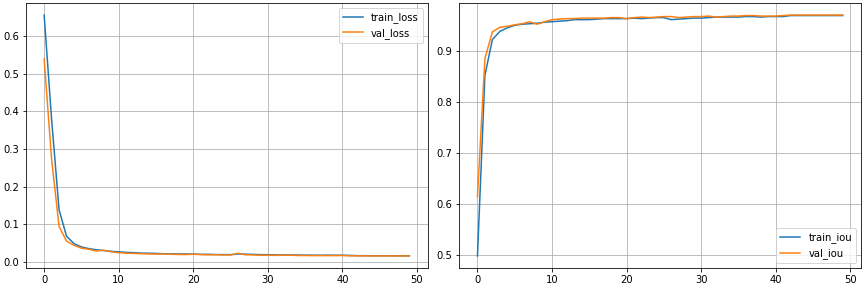

In [12]:
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir(f'{data_work}/')
    zip_name = f"{data_work}/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [13]:
download_file(f'{data_work}/checkpoints/best.pth', 'glasses_mobilenet_weights')

/kaggle/working/glasses_mobilenet_weights.zip

In [14]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_path,transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        self.root_path = root_path
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_path, self.df.iloc[index]['images'])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask_path = os.path.join(self.root_path, self.df.iloc[index]['masks'])
        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        aug = self.transforms_(image=img, mask=mask)            
        img, mask = aug['image'], aug['mask']
        img_view = np.copy(img)
        img = img / 255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        mask_view = np.copy(mask)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target, 'img_view':img_view, 'mask_view':mask_view}
        return sample

test_dataset = TestDataset(val_df, root_path, transforms_=val_transforms)

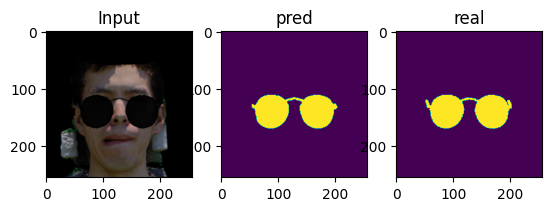

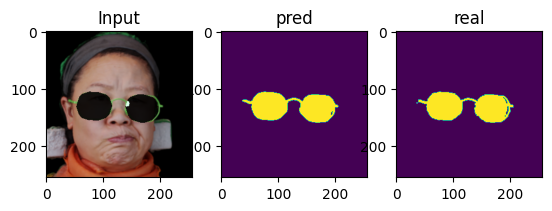

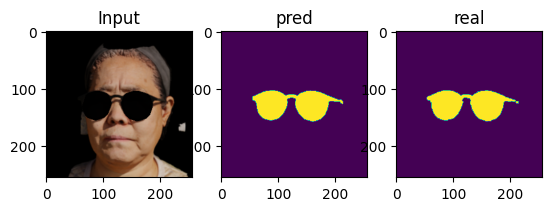

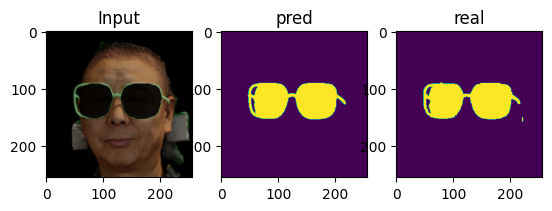

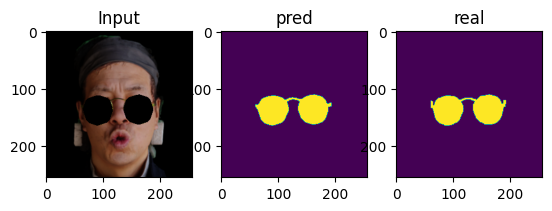

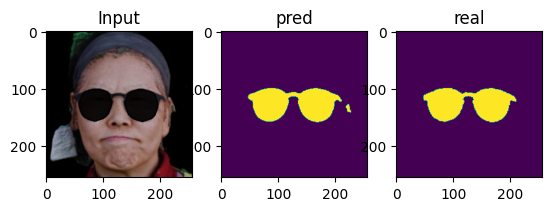

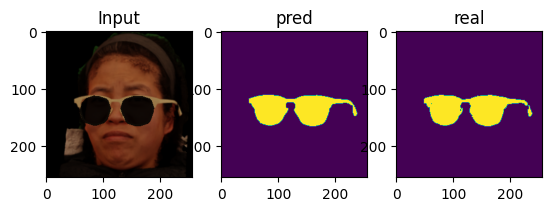

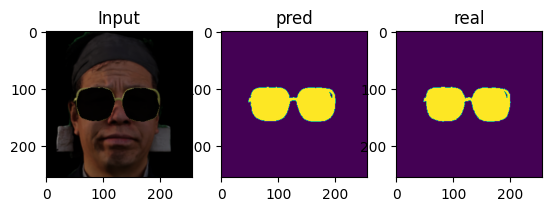

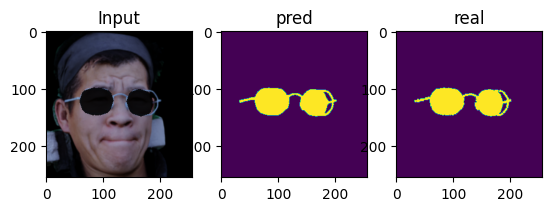

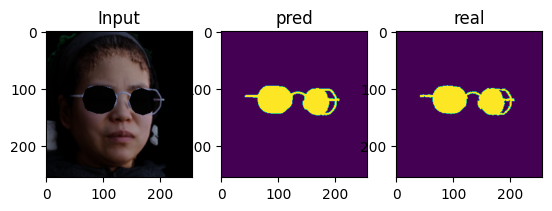

In [15]:
model.load_state_dict(torch.load("checkpoints/best.pth"))
model.to(device)
show_imgs = 10
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

for i in range(show_imgs):
    idx = random_list[i]
    sample = test_dataset[idx]
    pred = model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
    pred = torch.sigmoid(pred).squeeze(0).squeeze(0)
    pred = pred.data.cpu().numpy()
    pred = np.where(pred<0.5, 0, 1).astype(np.int16)
    pred_img = Image.fromarray(np.uint8(pred), 'L')

    img_view = sample['img_view']
    img_view = Image.fromarray(img_view, 'RGB')
    
    mask_view = sample['mask_view']
    mask_view = Image.fromarray(mask_view, 'L')
                
    f, axarr = plt.subplots(1, 3) 
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[1].imshow(pred_img)
    axarr[1].set_title('pred')
    axarr[2].imshow(mask_view)
    axarr[2].set_title('real')
    plt.show()